In [29]:
import tensorflow as tf
import gc
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Activation, BatchNormalization, Dropout, LSTM, ConvLSTM2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input,Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation, LSTM, ConvLSTM2D, Lambda, Reshape, BatchNormalization, Bidirectional
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,TensorBoard,TerminateOnNaN, LearningRateScheduler, CSVLogger
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from tensorflow.keras.layers import Lambda, Reshape, DepthwiseConv2D, ZeroPadding2D, Add, MaxPooling2D,Activation, Flatten, Conv2D, Dense, Input, Dropout, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers.experimental import preprocessing
from keras.applications import imagenet_utils
from tensorflow.keras import layers
!pip install tensorflow-addons
import tensorflow_addons as tfa
import pandas as pd
import numpy as np
import random
import keras
import shutil
import pathlib
import cv2
import os
import matplotlib.image as mpimg
import seaborn as sns
print(tf.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2.12.0


In [30]:
!nvidia-smi

Thu Jun 22 20:04:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    29W /  70W |   9155MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
train_dir = '/content/drive/MyDrive/Eye Disease Classification/DATASET/Preprocessed/train'
for dirpath, dirnames, filenames in os.walk(train_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 4 directories and 0 images in '/content/drive/MyDrive/Eye Disease Classification/DATASET/Preprocessed/train'.
There are 0 directories and 400 images in '/content/drive/MyDrive/Eye Disease Classification/DATASET/Preprocessed/train/cataract'.
There are 0 directories and 400 images in '/content/drive/MyDrive/Eye Disease Classification/DATASET/Preprocessed/train/diabetes'.
There are 0 directories and 400 images in '/content/drive/MyDrive/Eye Disease Classification/DATASET/Preprocessed/train/amd'.
There are 0 directories and 400 images in '/content/drive/MyDrive/Eye Disease Classification/DATASET/Preprocessed/train/normal'.


In [33]:
test_dir = '/content/drive/MyDrive/Eye Disease Classification/DATASET/Preprocessed/valid'
for dirpath, dirnames, filenames in os.walk(test_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 4 directories and 0 images in '/content/drive/MyDrive/Eye Disease Classification/DATASET/Preprocessed/valid'.
There are 0 directories and 100 images in '/content/drive/MyDrive/Eye Disease Classification/DATASET/Preprocessed/valid/amd'.
There are 0 directories and 100 images in '/content/drive/MyDrive/Eye Disease Classification/DATASET/Preprocessed/valid/normal'.
There are 0 directories and 100 images in '/content/drive/MyDrive/Eye Disease Classification/DATASET/Preprocessed/valid/diabetes'.
There are 0 directories and 100 images in '/content/drive/MyDrive/Eye Disease Classification/DATASET/Preprocessed/valid/cataract'.


In [34]:
def view_random_image(target_dir, target_class):
  target_folder = target_dir+target_class
  random_image = random.sample(os.listdir(target_folder), 1)
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");
  print(f"Image shape: {img.shape}")
  return img

Image shape: (1992, 2555, 3)


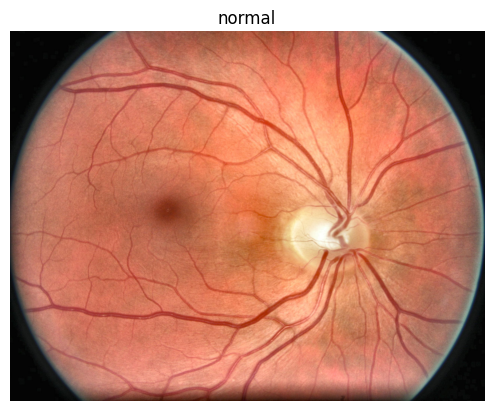

In [35]:
img = view_random_image(target_dir="/content/drive/MyDrive/Eye Disease Classification/DATASET/Preprocessed/train/",
                        target_class="normal")

In [36]:
EPOCHS = 100
from math import floor
N_FOLDS = 5
INIT_LR = 1e-3
T_BS = 16
V_BS = 16
decay_rate = 0.95
decay_step = 1
IMAGE_SIZE = [224,224]

In [37]:
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  # preprocessing.Rescaling(1./255)
], name="data_augmentation")

In [38]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode="categorical",
                                                                 batch_size=32,
                                                                 image_size=IMAGE_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMAGE_SIZE,
                                                                shuffle=False)

Found 1600 files belonging to 4 classes.
Found 400 files belonging to 4 classes.


In [39]:
base_model = tf.keras.applications.VGG19(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x)
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

80134624/80134624 [==============================] - 0s 0us/step


In [40]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 global_average_pooling (Glo  (None, 512)              0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 4)                 2052      
                                                                 
Total params: 20,026,436
Trainable params: 2,052
Non-trainable params: 20,024,384
_________________________________________________________________


In [41]:
opt = Adam(learning_rate=1e-3)
model.compile(optimizer=opt,
              loss="categorical_crossentropy",
              metrics=[keras.metrics.CategoricalAccuracy(name="accuracy")])

In [42]:
checkpoint = [ModelCheckpoint(filepath='best_model.h5',
                              monitor='val_accuracy',
                              mode='max',
                              verbose=1,
                              save_best_only=True,
                              save_weights_only=True)]

In [43]:
history = model.fit(train_data,
                    epochs=EPOCHS,
                    validation_data=test_data,
                    validation_steps=len(test_data),
                    callbacks=[checkpoint])

Epoch 1/100
50/50 [==============================] - ETA: 0s - loss: 2.8119 - accuracy: 0.3762
Epoch 1: val_accuracy improved from -inf to 0.58500, saving model to best_model.h5
50/50 [==============================] - 43s 771ms/step - loss: 2.8119 - accuracy: 0.3762 - val_loss: 1.1253 - val_accuracy: 0.5850
Epoch 2/100
50/50 [==============================] - ETA: 0s - loss: 0.9753 - accuracy: 0.6481
Epoch 2: val_accuracy improved from 0.58500 to 0.68000, saving model to best_model.h5
50/50 [==============================] - 28s 506ms/step - loss: 0.9753 - accuracy: 0.6481 - val_loss: 0.8053 - val_accuracy: 0.6800
Epoch 3/100
50/50 [==============================] - ETA: 0s - loss: 0.7410 - accuracy: 0.7113
Epoch 3: val_accuracy improved from 0.68000 to 0.72750, saving model to best_model.h5
50/50 [==============================] - 28s 508ms/step - loss: 0.7410 - accuracy: 0.7113 - val_loss: 0.6822 - val_accuracy: 0.7275
Epoch 4/100
50/50 [==============================] - ETA: 0s - l

In [44]:
model.load_weights('/content/best_model.h5')
_, accuracy = model.evaluate(test_data)
print(f"Validation accuracy: {round(accuracy * 100, 2)}%")

13/13 [==============================] - 5s 400ms/step - loss: 0.3321 - accuracy: 0.8900
Validation accuracy: 89.0%


In [45]:
pred_probs = model.predict(test_data, verbose=1)

13/13 [==============================] - 6s 431ms/step


In [46]:
pred_classes = pred_probs.argmax(axis=1)

y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

In [47]:
target_names = ['Amd', 'Cataract', 'Diabetes','Normal']
print(classification_report(y_labels,
                            pred_classes,
                            target_names=target_names, digits=4))

              precision    recall  f1-score   support

         Amd     0.9100    0.9100    0.9100       100
    Cataract     0.9706    0.9900    0.9802       100
    Diabetes     0.8523    0.7500    0.7979       100
      Normal     0.8273    0.9100    0.8667       100

    accuracy                         0.8900       400
   macro avg     0.8900    0.8900    0.8887       400
weighted avg     0.8900    0.8900    0.8887       400



In [48]:
cm = confusion_matrix(y_labels,pred_classes)

TP = cm[0, 0]
TN = cm[1:, 1:].sum()
FP = cm[0, 1:].sum()
FN = cm[1:, 0].sum()

Population = TN+FN+TP+FP
spesificity = TN / (TN + FP)
sensitivity = TP / (TP + FN)

print("True Positives:", TP)
print("False Positives:", FP)
print("True Negatives:", TN)
print("False Negatives:", FN)
print("Spesificity:", spesificity)
print("Sensitivity:", sensitivity)

True Positives: 91
False Positives: 9
True Negatives: 291
False Negatives: 9
Spesificity: 0.97
Sensitivity: 0.91


In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(20, 20), text_size=15, norm=False, savefig=False):

  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  n_classes = cm.shape[0]

  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues)
  fig.colorbar(cax)

  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes),
         yticks=np.arange(n_classes),
         xticklabels=labels,
         yticklabels=labels)

  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  threshold = (cm.max() + cm.min()) / 2.

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

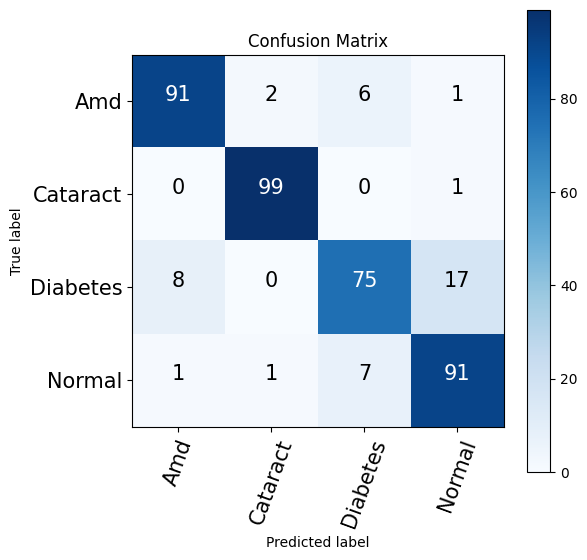

In [50]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=target_names,
                      figsize=(6, 6),
                      text_size=15,
                      norm=False,
                      savefig=True)

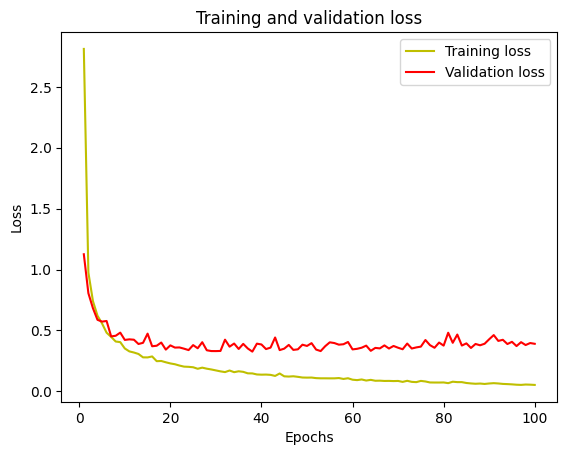

In [51]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

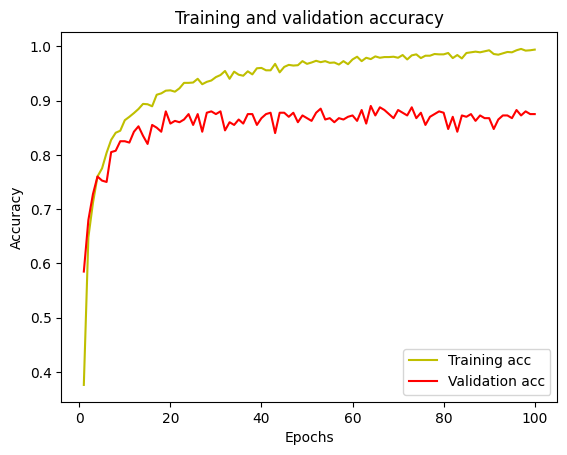

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()